In [2]:
def load_scan(data):
    # referred from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
    return data


def get_pixels_hu(image):
    # referred from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
    image = image.astype(np.int16)
    return np.int16(image)

def read_image(data):
    full_pixels =get_pixels_hu(load_scan(data))
    

    print(data.shape)
    
    return np.expand_dims(data, axis=-1)
     

def denormalize(image):
    img = image.copy()
    MIN_B= -1024.0
    MAX_B= 3072.0    

    return img * (MAX_B - MIN_B) + MIN_B

def trunc(mat):
    min = -160.0
    max = 240.0
    
    mat[mat <= min] = min
    mat[mat >= max] = max
    return mat
    

<KeysViewHDF5 ['data']>
128 128
(362, 362) (362, 362)
clean
(362, 362)


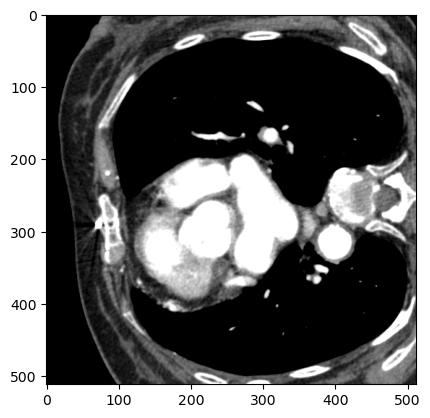

noisy
(362, 362)


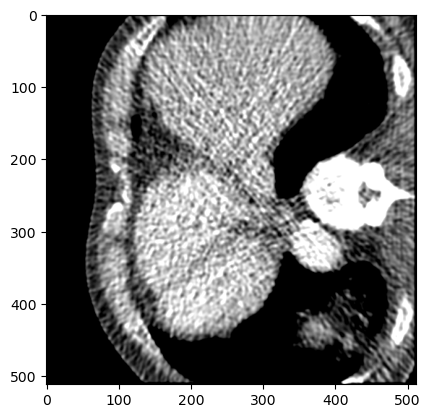

clean
(362, 362)


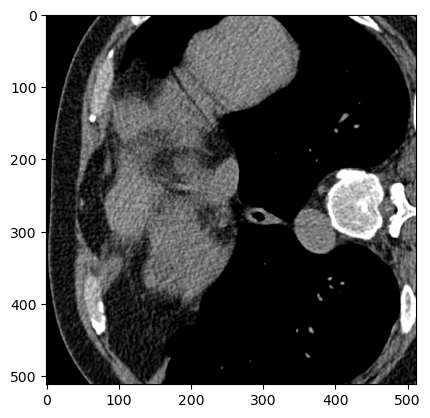

noisy
(362, 362)


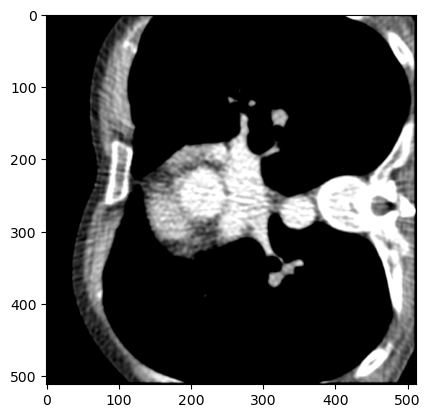

clean
(362, 362)


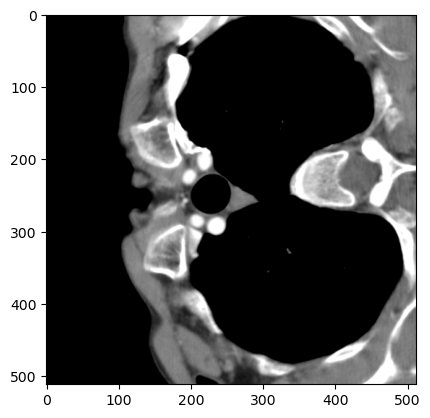

noisy
(362, 362)


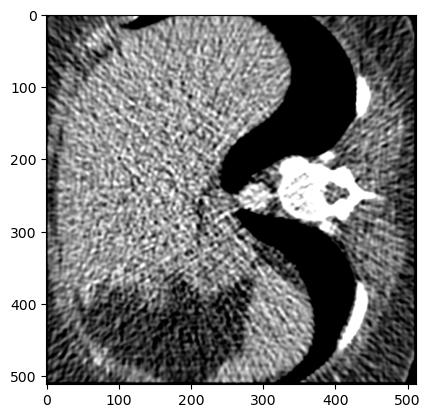

clean
(362, 362)


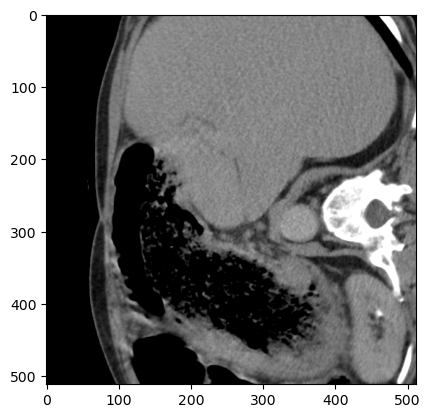

noisy
(362, 362)


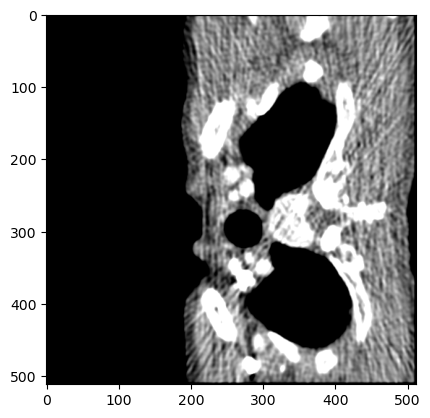

clean
(362, 362)


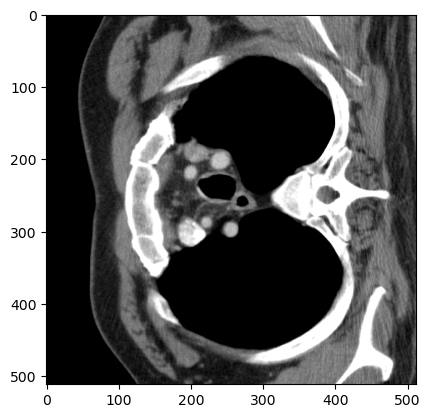

noisy
(362, 362)


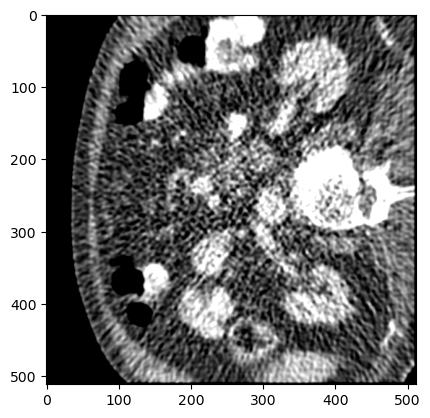

clean
(362, 362)


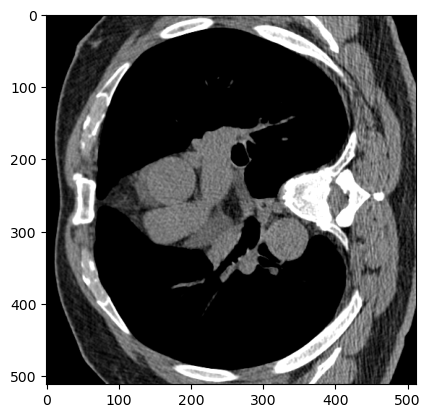

noisy
(362, 362)


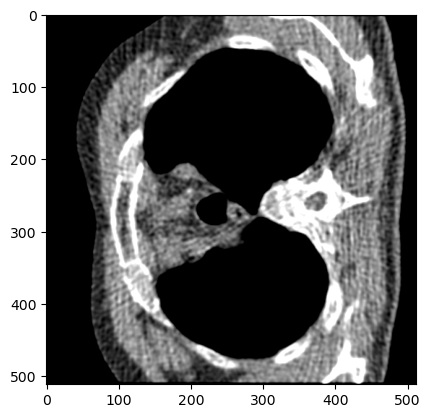

clean
(362, 362)


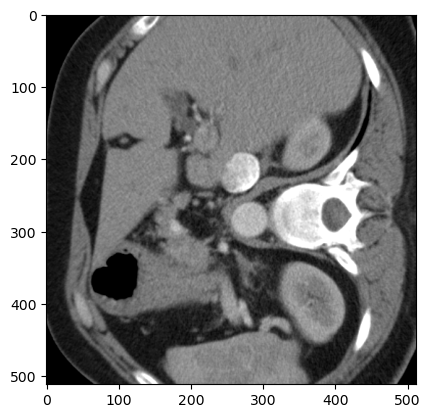

noisy
(362, 362)


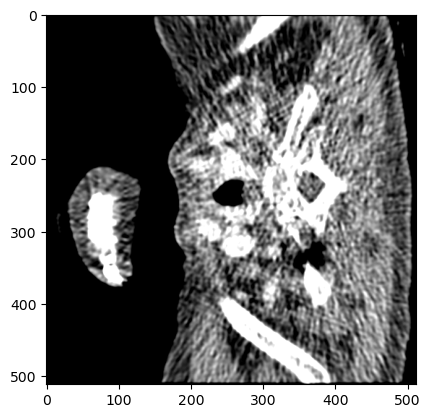

clean
(362, 362)


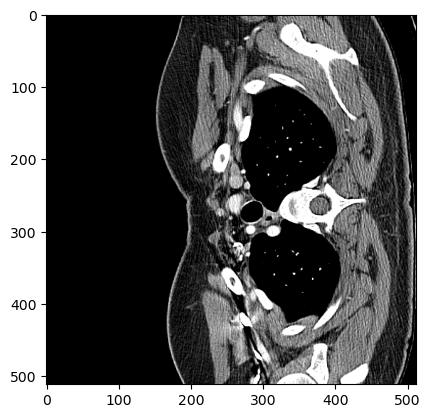

noisy
(362, 362)


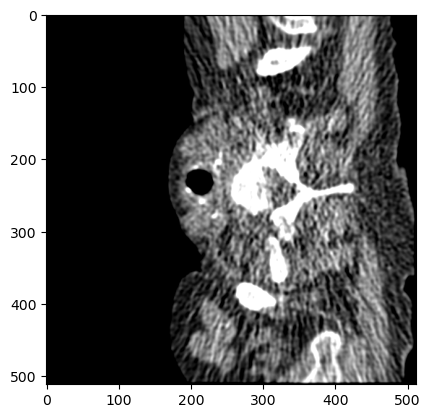

clean
(362, 362)


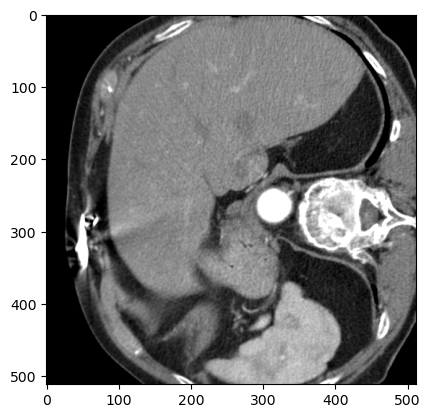

noisy
(362, 362)


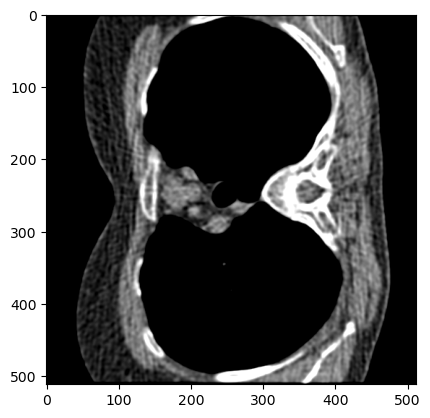

clean
(362, 362)


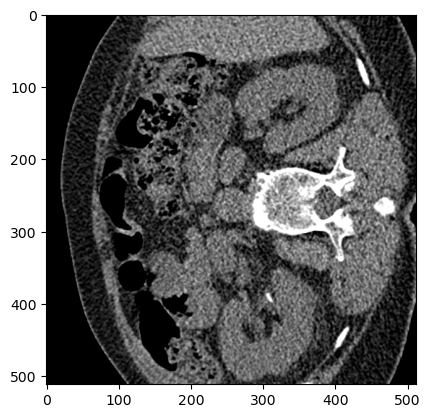

noisy
(362, 362)


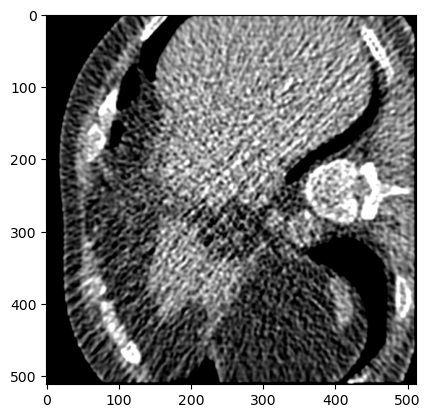

In [18]:
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt

clean_file_name = '../../../../Dataset/LoDoPaB-CT/ground_truth_validation/ground_truth_validation_000.hdf5'
noisy_file_name = '../../../../Dataset/LoDoPaB-CT/observation_validation/observation_validation_000.hdf5'
noisy_file_name = 'C:/Users/Tarun/Downloads/reco_000.hdf5'

clean = h5py.File(clean_file_name)
noisy = h5py.File(noisy_file_name)

print(noisy.keys())
a_group_key = list(clean.keys())[0]
b_group_key = list(noisy.keys())[0]

clean_data = list(clean[a_group_key])
noisy_data = list(noisy[b_group_key])

print(len(clean_data), len(noisy_data))
print(clean_data[0].shape, noisy_data[0].shape)
for i in range(0, 10):
    print('clean')
    c_data = read_image(clean_data[i])
    c_data = np.expand_dims(cv2.resize(c_data, (512, 512)), -1)
    plt.imshow(trunc(denormalize(c_data)), cmap='gray', vmin=-160.0, vmax=240.0)
    plt.show()

    print('noisy')
    c_data = read_image(noisy_data[i])
    c_data = np.expand_dims(cv2.resize(c_data, (512, 512)), -1)
    plt.imshow(trunc(denormalize(c_data)), cmap='gray', vmin=-160.0, vmax=240.0)
    plt.show()
    #print(img.shape)
    #img.show()

In [4]:
# From : https://raw.githubusercontent.com/jleuschn/lodopab_challenge/master/data_util.py

# -*- coding: utf-8 -*-
import h5py
import numpy as np

def read_h5_file(filename, out=None, n=None):
    """
    Read images from HDF5 file into an array.

    Parameters
    ----------
    filename : str
        Filename (path) of the HDF5 file.
    out : array, optional
        Array in which to store the read data.
        If `None`, a new array is created.
    n : int, optional
        Number of images to read.
        If `None`, it is inferred from `out` if provided or from the file
        otherwise.

    Raises
    ------
    ValueError
        If the dataset in the file does not have three dimensions or if
        `n` is too large.

    Returns
    -------
    out : array
        Array holding the read data.
    """
    with h5py.File(filename, 'r') as file:
        shape = file['data'].shape
    if len(shape) != 3:
        raise ValueError('expected dataset of shape (n, im_x, im_y)')
    if n is None:
        n = out.shape[0] if out is not None else shape[0]
    if shape[0] < n:
        raise ValueError('requested {:d} images, but axis 0 of dataset only '
                         'has length {:d}'.format(n, shape[0]))
    if out is not None and out.shape[0] < n:
        raise ValueError('requested {:d} images, but axis 0 of `out` only has '
                         'length {:d}'.format(n, out.shape[0]))
    if out is None:
        out = np.zeros((n,) + shape[1:], dtype=np.float32)
    with h5py.File(filename, 'r') as file:
        file['data'].read_direct(out, np.s_[:n], np.s_[:n])
    return out


In [5]:
h5_contents = np.squeeze(read_h5_file(noisy_file_name, n=1))
h5_contents.shape

(1000, 513)

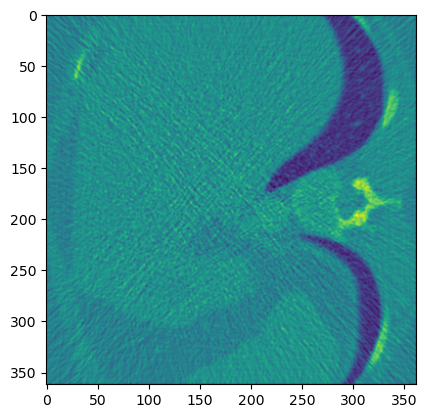

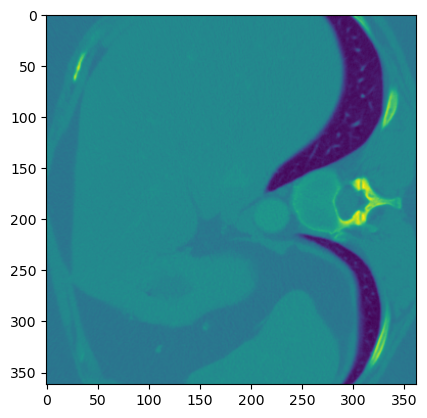

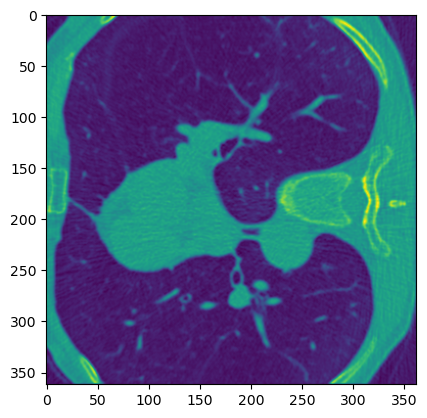

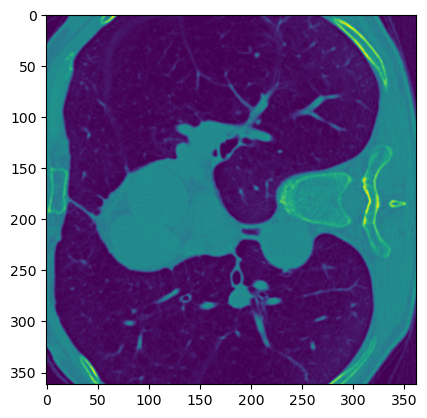

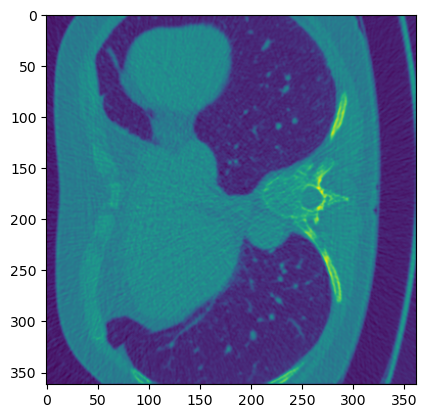

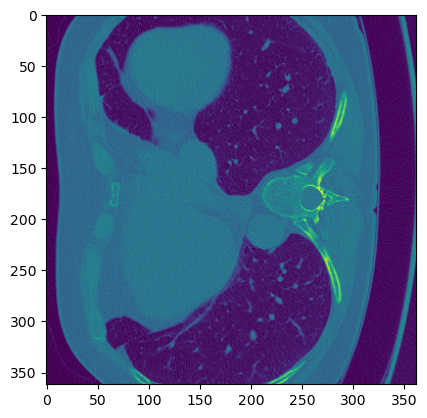

In [6]:
import torch
import matplotlib.pyplot as plt

dataset = torch.load('10_lodopab_ct_test_samples.pt')


for sample_at in range(3):
    obs, gt = dataset['obs'][sample_at], dataset['gt'][sample_at]
    obs = obs.squeeze(0)
    plt.imshow(obs)
    plt.show()
    gt = gt.squeeze(0)
    plt.imshow(gt)
    plt.show()

In [7]:
from dival import get_standard_dataset
from dival.measure import PSNR
from dival.reconstructors.tvadam_ct_reconstructor import TVAdamCTReconstructor
from dival.reference_reconstructors import (
    check_for_params, download_params, get_params_path)
from dival.util.plot import plot_images
import matplotlib.pyplot as plt

In [8]:

IMPL = 'astra_cuda'

In [11]:
from dival import get_standard_dataset
from dival.measure import PSNR
from dival.reconstructors.tvadam_ct_reconstructor import TVAdamCTReconstructor
from dival.reference_reconstructors import (
    check_for_params, download_params, get_params_path)
from dival.util.plot import plot_images
import matplotlib.pyplot as plt

IMPL = 'astra_cuda'

dataset = get_standard_dataset('lodopab', impl=IMPL)
TEST_SAMPLE = 0
obs, gt = dataset.get_sample(TEST_SAMPLE, 'test')

def callback_func(iteration, reconstruction, loss):
    _, ax = plot_images([reconstruction, gt],
                        fig_size=(10, 4))
    ax[0].set_xlabel('loss: {:f}'.format(loss))
    ax[0].set_title('TV iteration {:d}'.format(iteration))
    ax[1].set_title('ground truth')
    ax[0].figure.suptitle('test sample {:d}'.format(TEST_SAMPLE))
    plt.show()

reconstructor = TVAdamCTReconstructor(
    dataset.get_ray_trafo(impl=IMPL),
    callback_func=callback_func, callback_func_interval=100)

#%% obtain reference hyper parameters
if not check_for_params('tvadam', 'lodopab'):
    download_params('tvadam', 'lodopab')
params_path = get_params_path('tvadam', 'lodopab')
reconstructor.load_params(params_path)

#%% evaluate
reco = reconstructor.reconstruct(obs)
psnr = PSNR(reco, gt)

print('psnr: {:f}'.format(psnr))
_, ax = plot_images([reco, gt],
                    fig_size=(10, 4))
ax[0].set_xlabel('PSNR: {:.2f}'.format(psnr))
ax[0].set_title('TVAdamReconstructor')
ax[1].set_title('ground truth')
ax[0].figure.suptitle('test sample {:d}'.format(TEST_SAMPLE))


The LoDoPaB-CT dataset could not be found under the configured path 'C:\Users\Tarun\.dival\datasets\lodopab'.
Do you want to download it now? (y: download, n: input other path)
Path to LoDoPaB dataset:
updated configuration in 'C:\Users\Tarun\.dival\config.json':
'lodopab_dataset/data_path' = C:\Users\Tarun\Desktop\Files\College\FinalYearProject\Dataset\LoDoPaB-CT
The LoDoPaB-CT dataset could not be found under the configured path 'C:\Users\Tarun\Desktop\Files\College\FinalYearProject\Dataset\LoDoPaB-CT'.
Do you want to download it now? (y: download, n: input other path)
Path to LoDoPaB dataset:
updated configuration in 'C:\Users\Tarun\.dival\config.json':
'lodopab_dataset/data_path' = C:\Users\Tarun\Desktop\Files\College\FinalYearProject\Dataset\LoDoPaB-CT
The LoDoPaB-CT dataset could not be found under the configured path 'C:\Users\Tarun\Desktop\Files\College\FinalYearProject\Dataset\LoDoPaB-CT'.
Do you want to download it now? (y: download, n: input other path)


KeyboardInterrupt: Interrupted by user

(1000, 513)


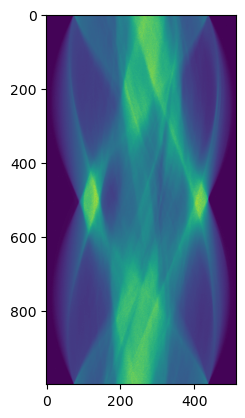

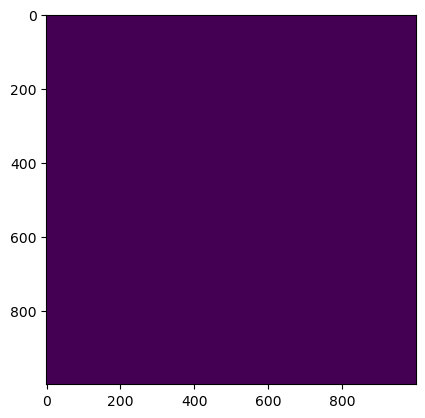

AttributeError: module 'SimpleITK.SimpleITK' has no attribute 'BackProjectionFilter'

In [41]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pydicom

# Load your LDCT image (replace 'your_image_path.nii.gz' with the actual path)
image_path = 'C:/Users/Tarun/Desktop/Files/College/FinalYearProject/Dataset/LoDoPaB-CT/observation_train_000.hdf5'
ldct_array = read_h5_file(image_path, out=None, n=None)[0]
print(ldct_array.shape)
plt.imshow(ldct_array)
plt.show()

from skimage.transform import iradon_sart
reconstruction_sart = iradon_sart(ldct_array)
plt.imshow(trunc(denormalize(reconstruction_sart)))
plt.show()

# Display the original LDCT image

# Perform filtered backprojection (replace filter_params with your specific parameters)
filtered_backprojection = sitk.SimpleITK.BackProjectionFilter(ldct_array, filter_params)

# Create a SimpleITK image from the reconstructed array
reconstructed_image = sitk.GetImageFromArray(filtered_backprojection)

# Display the reconstructed image
reconstructed_array = sitk.GetArrayFromImage(reconstructed_image)
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_array[0, :, :], cmap='gray')
plt.title('Reconstructed Image')

# Show the plots
plt.show()
